In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:
datapath = "/home/haue/repositories/Masters/data/" 
Al_path = datapath + "bananas/Al/BanAnaToAboveBan/"
P_path = datapath + "bananas/P"
Si_path = datapath + "bananas/Si"
Mg_path = datapath + "bananas/Mg"


Al_files = glob.glob(os.path.join(Al_path, "*mlio.root"))
#P_files = glob.glob(os.path.join(P_path, "*mlio.root"))
#Si_files = glob.glob(os.path.join(Si_path, "*mlio.root"))
#Mg_files = glob.glob(os.path.join(Mg_path, "*mlio.root"))

In [3]:
# Storing the data in a dictionary for easy access

### Should be a more intuitive version than the ones used in Bananachecks...

data_files = {
    "Al": Al_files
    #"P": P_files,
    #"Mg": Mg_files,
    #"Si": Si_files
}
data_collection = {
      "Al": {},
    #"P": {},
    #"Mg": {},
    #"Si": {},
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}


for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")
    




Processing Al: 100%|██████████ 50/50 [00:48<00:00,  1.04file/s]


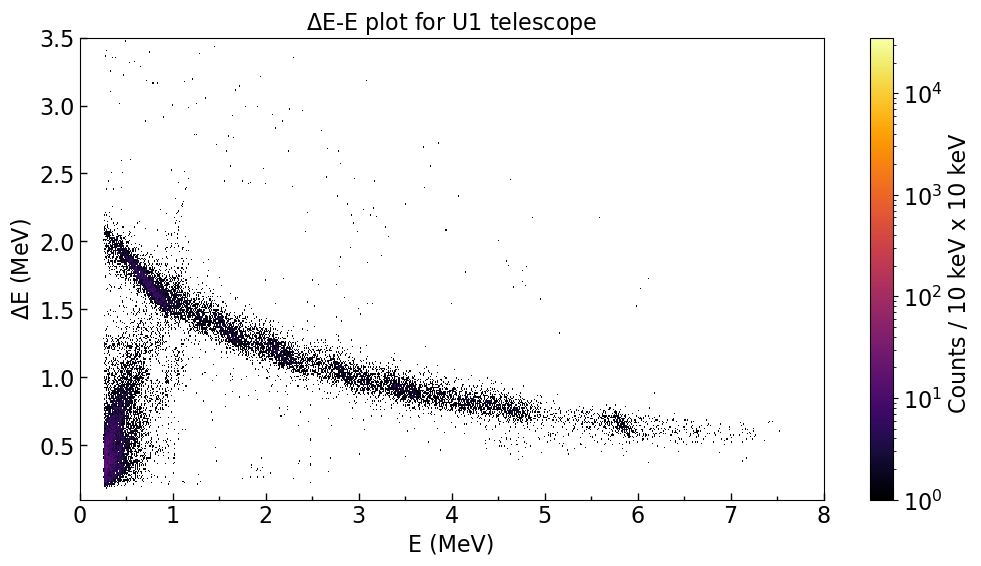

In [8]:
plt.rcParams.update({'font.size': 16})

isotopes = ["Al"]#, "Si", "P", "Mg"]
for i in range(1):
    for isot in isotopes:
        plt.figure(figsize=(12,6))
        if(i==3):
            plt.hist2d(data_collection[isot][f"id{i}"]["bEdep"], data_collection[isot][f"id{i}"]["fEdep"], bins=(np.arange(0, 10, 0.01), np.arange(0, 8, 0.01)),
                    cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        else:
            plt.hist2d(data_collection[isot][f"id{i}"]["bEdep"], data_collection[isot][f"id{i}"]["fEdep"], bins=(np.arange(0, 10, 0.01), np.arange(0, 4, 0.01)),
                    cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ", fontsize=16)
        plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
        plt.xlim(0, 8)
        if (i==3):
            plt.ylim(0, 8)
        else:
            plt.ylim(0.1,3.5)
        plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
        plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
        plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
        plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)

        plt.xlabel("E (MeV)", fontsize=16)
        plt.ylabel(r"$\Delta$E (MeV)", fontsize=16)
        plt.title(rf"$\Delta$E-E plot for U{i+1} telescope", fontsize=16)
        plt.savefig("banana.pdf")
